In [3]:
# **Facial Emotion Recognition**




# Dataset - https://www.kaggle.com/datasets/msambare/fer2013/data

In [4]:
# 1.Import thư viện
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, AveragePooling2D,
                                     Dropout, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import (CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau)
import os
import seaborn as sns
from tensorflow.keras.optimizers import Adam

In [5]:
# 2.Thiết lập đường dẫn & tham số
base_dir = 'E:/Đại học/Năm 4/Kì 2/AI nâng cao/emtion recognition cnn/fer2013' 
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
img_size = (48, 48) # resize ảnh về 48x48 pixels
batch_size = 32
num_classes = 7 
# 7 cảm xúc (angry - tức giận, disgust - ghê sợ, fear - sợ hãi, happy - vui vẻ, sad - buồn bã, surprise - ngạc nhiên, neutral - trung lập)

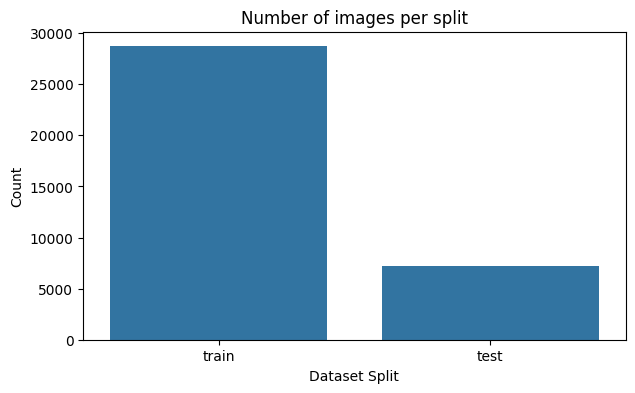

{'train': 28709, 'test': 7206}


In [6]:
base_dir = 'fer2013'
usage_counts = {}

for usage in ['train', 'test']:
    usage_path = os.path.join(base_dir, usage)
    if os.path.isdir(usage_path):
        total = 0
        for emotion in os.listdir(usage_path):
            emotion_path = os.path.join(usage_path, emotion)
            if os.path.isdir(emotion_path):
                num_images = len([img for img in os.listdir(emotion_path) if img.lower().endswith(('jpg', 'png', 'jpeg'))])
                total += num_images
        usage_counts[usage] = total

# Vẽ biểu đồ
plt.figure(figsize=(7,4))
sns.barplot(x=list(usage_counts.keys()), y=list(usage_counts.values()))
plt.xlabel('Dataset Split')
plt.ylabel('Count')
plt.title('Number of images per split')
plt.show()
print(usage_counts)


In [7]:
# 3.Tạo Data Generator cho train/val/test
train_datagen = ImageDataGenerator(
    rescale=1./255, # chuẩn hoá pixel về khoảng [0, 1]
    rotation_range=10, # xoay ảnh trong khoảng 10 độ
    width_shift_range=0.1, # dịch ngang 10% chiều rộng ảnh
    height_shift_range=0.1, # dịch dọc 10% chiều cao ảnh
    zoom_range=0.1,  # phóng to/thu nhỏ ảnh trong khoảng 10%
    horizontal_flip=True, # lật ngang ảnh
    validation_split=0.2   # 80% train, 20% validation từ train folder
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size, 
    color_mode='grayscale', # chuyển ảnh sang ảnh xám
    batch_size=batch_size,
    class_mode='categorical', # one-hot encoding cho các lớp cảm xúc
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7206 images belonging to 7 classes.


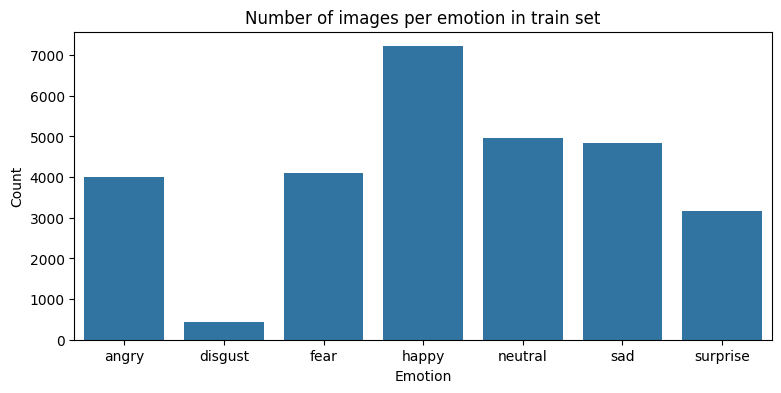

{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}


In [8]:
train_dir = 'fer2013/train'

emotion_counts = {}
for emotion in os.listdir(train_dir):
    emotion_path = os.path.join(train_dir, emotion)
    if os.path.isdir(emotion_path):
        num_images = len([img for img in os.listdir(emotion_path) if img.lower().endswith(('jpg', 'png', 'jpeg'))])
        emotion_counts[emotion] = num_images

# Vẽ biểu đồ
plt.figure(figsize=(9,4))
sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Number of images per emotion in train set')
plt.show()
print(emotion_counts)


In [9]:
# 4.Xây dựng mô hình CNN
model = Sequential()
# Dùng 2 lớp tích chập với 16 kernel kích thức 7x7 để lấy các đặc trưng lớn, tổng quát trên khuôn mặt
model.add(Conv2D(16, (7, 7), padding='same', input_shape=(48, 48, 1), name='image_array'))
# Chuẩn hoá BatchNormalization giúp tăng tốc độ huấn luyện và ổn định mô hình
model.add(BatchNormalization())
model.add(Conv2D(16, (7, 7), padding='same'))
model.add(BatchNormalization())
# Hàm kích hoạt ReLU giúp phi tuyến tính hóa mô hình
model.add(Activation('relu'))
# AveragePooling2D giảm chiều không gian, đồng thời giữ lại các đặc trưng quan trọng.
model.add(AveragePooling2D((2, 2), padding='same'))
# Dropout để giảm overfitting
model.add(Dropout(.5))

# Tiếp tục với 2 lớp tích chập với 32 kernel kích thức 5x5, giúp mô hình học các đặc trưng chi tiết hơn
model.add(Conv2D(32, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D((2, 2), padding='same'))
model.add(Dropout(.5))

# Tiếp tục với 2 lớp tích chập với 64 kernel kích thức 3x3, giúp mô hình học các đặc trưng tinh vi hơn (mắt, miệng ...)
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D((2, 2), padding='same'))
model.add(Dropout(.5))

# Tiếp tục với 2 lớp tích chập với 128 kernel kích thức 3x3, giúp mô hình học các đặc trưng tinh vi hơn (mắt, miệng ...)
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D((2, 2), padding='same'))
model.add(Dropout(.5))

# Số kernel đạt 256 để học các đặc trưng rất sâu
model.add(Conv2D(256, (3, 3), padding='same')) 
model.add(BatchNormalization())
model.add(Conv2D(num_classes, (3, 3), padding='same')) # num_classes kernel, ứng với số lớp cảm xúc cần phân loạI
# GlobalAveragePooling2D giúp giảm chiều không gian xuống còn 1x1, giữ lại các đặc trưng quan trọng nhất
model.add(GlobalAveragePooling2D())
# Softmax trả về xác suất dự đoán cho từng lớp cảm xúc.
model.add(Activation('softmax', name='predictions'))

learning_rate = 0.005
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_array (Conv2D)            │ (None, 48, 48, 16)     │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 24, 24, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 12, 12, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 6, 6, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 642,935 (2.45 MB)

 Trainable params: 641,463 (2.45 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [10]:
# 5.Cài đặt callbacks
callbacks = [
    CSVLogger('training.log', append=False),
    EarlyStopping(monitor='val_loss', patience=30, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [11]:
# số lượng ảnh training / batch_size -> số batch trong tập train
# 22972 ảnh training / 32 = 718 batch

In [12]:
# 6.Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.2165 - loss: 2.1270
Epoch 1: val_loss improved from inf to 1.82688, saving model to best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 364s 496ms/step - accuracy: 0.2165 - loss: 2.1267 - val_accuracy: 0.2397 - val_loss: 1.8269 - learning_rate: 0.0050
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2580 - loss: 1.7782
Epoch 2: val_loss improved from 1.82688 to 1.76387, saving model to best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 77s 107ms/step - accuracy: 0.2580 - loss: 1.7782 - val_accuracy: 0.2853 - val_loss: 1.7639 - learning_rate: 0.0050
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.2866 - loss: 1.7387
Epoch 3: val_loss improved from 1.76387 to 1.74041, saving model to best_model.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 186s 259ms/step - accuracy: 0.2866 - loss: 1.7386 - val_accuracy: 0.3048 - val_loss: 1.7404 - learning_rate: 0.0050
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

In [13]:
# 7.Đánh giá trên test set
score = model.evaluate(test_generator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

# số ảnh test / batch size -> số batch trong tập test
# 7206 ảnh test / 32 = 226 batch

226/226 ━━━━━━━━━━━━━━━━━━━━ 52s 233ms/step - accuracy: 0.5003 - loss: 1.2710
Test loss: 1.214647650718689
Test accuracy: 54.19095158576965


226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


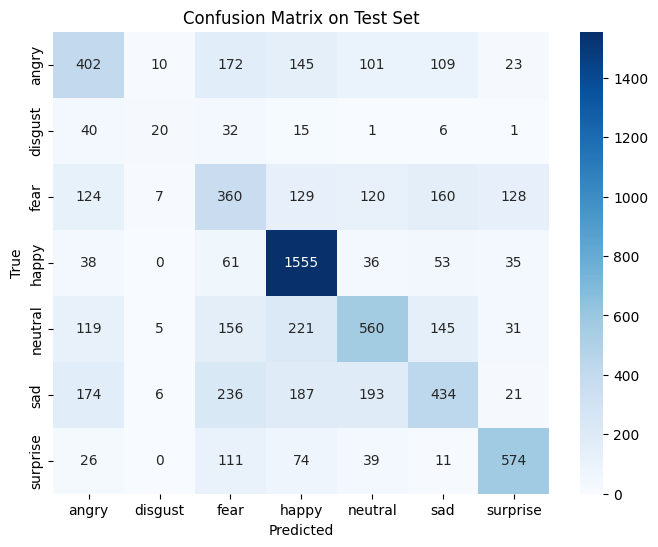

              precision    recall  f1-score   support

       angry       0.44      0.42      0.43       962
     disgust       0.42      0.17      0.25       115
        fear       0.32      0.35      0.33      1028
       happy       0.67      0.87      0.76      1778
     neutral       0.53      0.45      0.49      1237
         sad       0.47      0.35      0.40      1251
    surprise       0.71      0.69      0.70       835

    accuracy                           0.54      7206
   macro avg       0.51      0.47      0.48      7206
weighted avg       0.53      0.54      0.53      7206



In [14]:
# Đánh giá Confusion Matrix trên tập test
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Lấy ground truth và predict cho toàn bộ test set
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Classification report (precision, recall, f1...)
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))


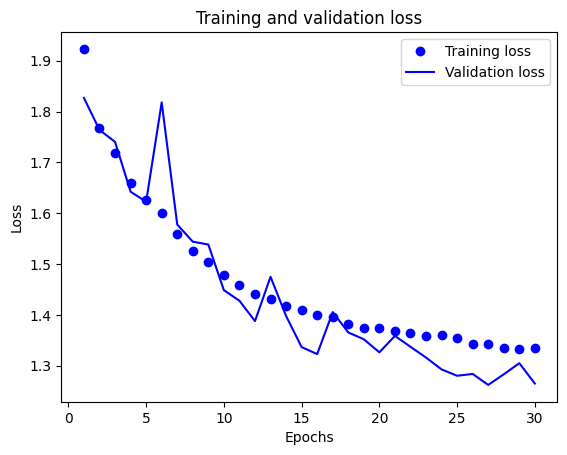

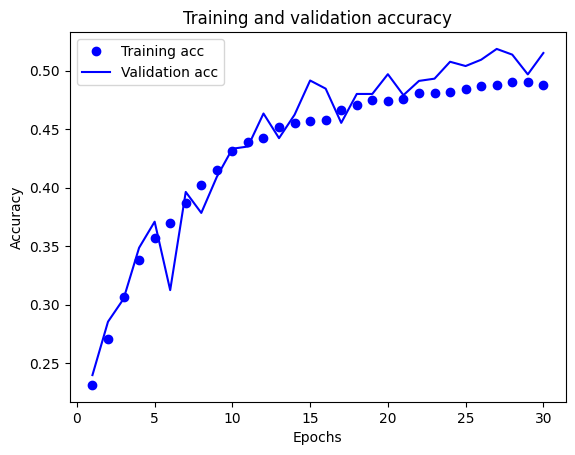

In [15]:
# 8.Vẽ đồ thị loss/accuracy
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

emotion_dict = {
    0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy",
    4: "Sad", 5: "Surprise", 6: "Neutral"
}

def predict_emotion(img_path, scale_percent=50):
    # Bước 1: Đọc ảnh gốc RGB
    img_color = Image.open(img_path)
    width, height = img_color.size

    # Nếu muốn giữ nguyên ảnh gốc thì scale_percent=None hoặc 100
    if scale_percent is not None and scale_percent == 40:
        # Tính kích thước mới theo phần trăm
        new_width = int(width * scale_percent / 100)
        new_height = int(height * scale_percent / 100)
        img_display = img_color.resize((new_width, new_height))
    else:
        img_display = img_color

    # Bước 2: Chuẩn bị ảnh grayscale 48x48 cho model dự đoán
    img_gray = image.load_img(img_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img_gray)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    preds = model.predict(img_array)
    emotion_idx = np.argmax(preds)

    # Bước 3: In kết quả và hiển thị ảnh màu đã resize
    print(f"Emotion: {emotion_dict[emotion_idx]}")
    plt.imshow(img_display)
    plt.title(f'Predicted: {emotion_dict[emotion_idx]}')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Emotion: Fear


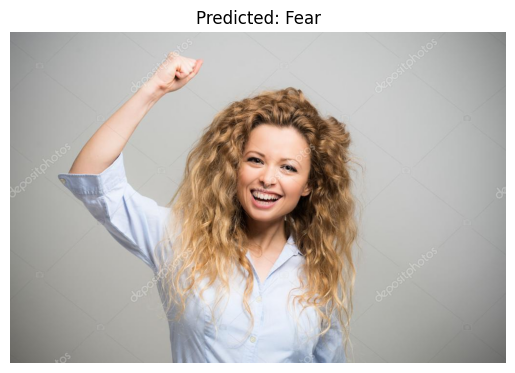

In [101]:
predict_emotion('fer2013/test/happy/4.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Emotion: Angry


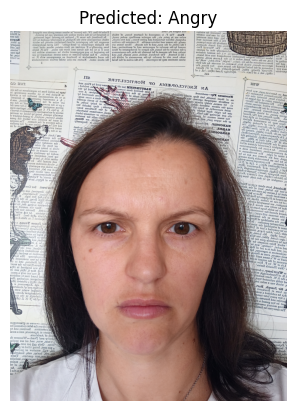

In [68]:
predict_emotion('fer2013/test/angry/6.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Emotion: Happy


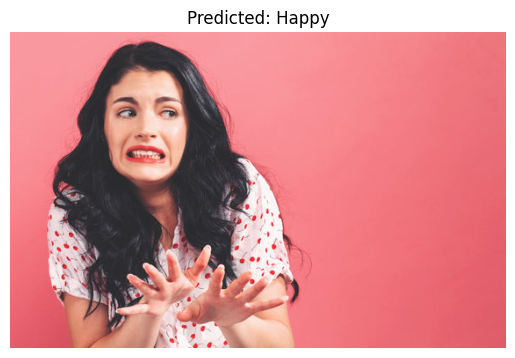

In [90]:
predict_emotion('fer2013/test/disgust/2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Emotion: Fear


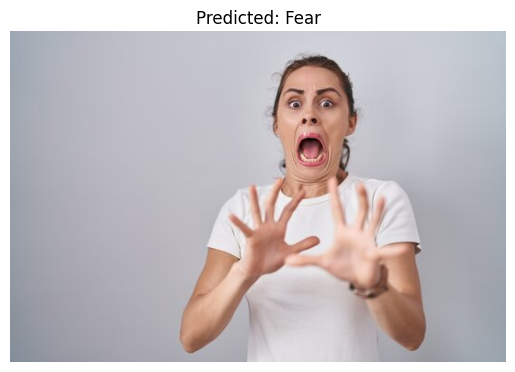

In [89]:
predict_emotion('fer2013/test/fear/2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Emotion: Happy


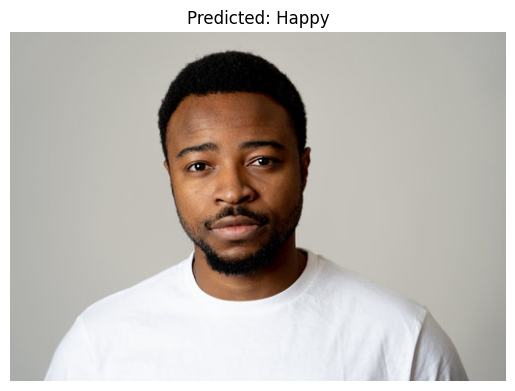

In [91]:
predict_emotion('fer2013/test/neutral/1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Emotion: Fear


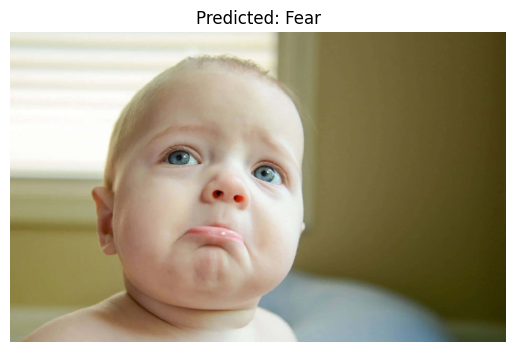

In [96]:
predict_emotion('fer2013/test/sad/3.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Emotion: Happy


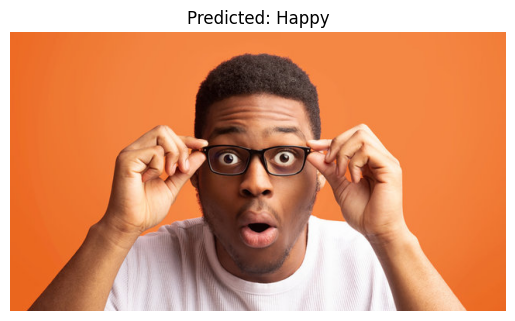

In [100]:
predict_emotion('fer2013/test/surprise/1.jpg')